In [1]:
# Importing and Initializing Spark session
import warnings
warnings.filterwarnings('ignore')
import nltk
# nltk.download('wordnet')
import matplotlib.pyplot as plt
import numpy as np
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures
from nltk import ngrams
import nltk, re, string, collections
from nltk.util import ngrams
from wordcloud import WordCloud
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, when, count,udf, col, lower, regexp_replace
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from nltk.stem import WordNetLemmatizer
from pyspark.sql.types import ArrayType,StringType

spark = SparkSession.builder.appName('guess_the_product').getOrCreate()

In [2]:
# Working Directory Info.
import os
os.getcwd()

'/home/chexki/Assignment'

In [3]:
# Importing Required Data Files in Spark dataframe

data = spark.read.csv('train_set.csv',inferSchema=True,header=True)
print("Data :",(data.count(), len(data.columns)))

Data : (5288, 6)


In [4]:
# Data overview

def data_information(input_):
    # Data type info
    coltypes = pd.DataFrame(input_.dtypes, columns = ['Column Name','Data type']).set_index('Column Name').T.reset_index().rename(columns = {'index': 'summary'})
    # Missing Values
    missing_df = pd.DataFrame(input_.select([count(when(isnan(c), c)).alias(c) for c in input_.columns]).toPandas())
    # Unique levels
    unique_vals = [input_.select(i).distinct().count() for i in input_.columns]
    missing_df = missing_df.append(dict( zip( input_.columns, unique_vals)), ignore_index=True)
    missing_df['summary'] = ['Missing_values','Unique_levels'] 
    # Data description
    data_information = pd.DataFrame(input_.describe().toPandas())
    # Collecting information factors
    output = pd.concat([missing_df,coltypes,data_information])
    return output

data_information(data)

,Inv_Id,Vendor_Code,GL_Code,Inv_Amt,Item_Description,Product_Category,summary
0,0,0,0,0,0,0,Missing_values
1,5288,1206,9,4099,5281,36,Unique_levels
0,int,string,string,double,string,string,Data type
0,5288,5288,5288,5288,5288,5288,count
1,19016.049924357034,None,None,49.89003403933447,None,None,mean
2,2310.7395486597293,None,None,28.835716244613508,None,None,stddev
3,15001,VENDOR-1000,GL-2182000,0.01,2000-Dec Associated Dry Goods Corp 1969 Quali...,CLASS-1248,min
4,23010,VENDOR-2559,GL-6121905,99.99,World Wide Ltd Contingent Labor/Temp Labor 201...,CLASS-2241,max


In [5]:
# Dropping irrelevent feature - Invoice id

data = data.drop("Inv_Id")

In [7]:
# Len of words used against category.
# Most Amount against category

In [8]:
from pyspark.sql.functions import length
data = data.withColumn('text_length',length(data['Item_Description']))

data.show()

+-----------+----------+-------+--------------------+----------------+-----------+
|Vendor_Code|   GL_Code|Inv_Amt|    Item_Description|Product_Category|text_length|
+-----------+----------+-------+--------------------+----------------+-----------+
|VENDOR-1676|GL-6100410|  83.24|Artworking/Typese...|      CLASS-1963|        113|
|VENDOR-1883|GL-2182000|  51.18|Auto Leasing Corp...|      CLASS-1250|        111|
|VENDOR-1999|GL-6050100|  79.02|Store Management ...|      CLASS-1274|         70|
|VENDOR-1771|GL-6101400|   48.5|Store Constructio...|      CLASS-1522|        107|
|VENDOR-1331|GL-2182000|  63.35|Jul 2015 Aydin Co...|      CLASS-1376|        110|
|VENDOR-2076|GL-6101400|  32.28|Final Site Clean ...|      CLASS-1522|         97|
|VENDOR-1802|GL-6050310|   5.38|Travel and Entert...|      CLASS-1758|        160|
|VENDOR-1191|GL-6101400|  31.21|General Contracto...|      CLASS-1522|        110|
|VENDOR-2120|GL-6100410|  42.89|Aquila Distributo...|      CLASS-1963|        154|
|VEN

In [9]:
from pyspark.sql.functions import sum,avg,max,min,mean,count

Product_level_info = data.groupBy("Product_Category").agg(count("text_length").alias("Total_records"),
                                     sum("Inv_Amt").alias("Total_Inv_Amt"),
                                     avg("Inv_Amt").alias("Avg_Inv_Amt"),
                                     avg("text_length").alias("Avg_text_length"))
pd_products = Product_level_info.toPandas()
# pd_products.set_index('Product_Category',inplace=True)
Product_level_info.show()

+----------------+-------------+------------------+------------------+------------------+
|Product_Category|Total_records|     Total_Inv_Amt|       Avg_Inv_Amt|   Avg_text_length|
+----------------+-------------+------------------+------------------+------------------+
|      CLASS-1652|           14| 819.7300000000001| 58.55214285714287|113.21428571428571|
|      CLASS-1828|          107| 5638.989999999999|52.700841121495316|  87.4392523364486|
|      CLASS-1758|         1421| 71136.15000000005| 50.06062631949335|159.23786066150598|
|      CLASS-1248|            4|            173.73|           43.4325|             101.5|
|      CLASS-1983|           16|            874.75|         54.671875|          139.6875|
|      CLASS-1850|           51|2521.0500000000006| 49.43235294117648| 99.37254901960785|
|      CLASS-2141|          103| 5021.150000000002|48.749029126213614|119.90291262135922|
|      CLASS-1567|           80|3687.0100000000007| 46.08762500000001|            107.45|
|      CLA

<AxesSubplot:ylabel='Product_Category'>

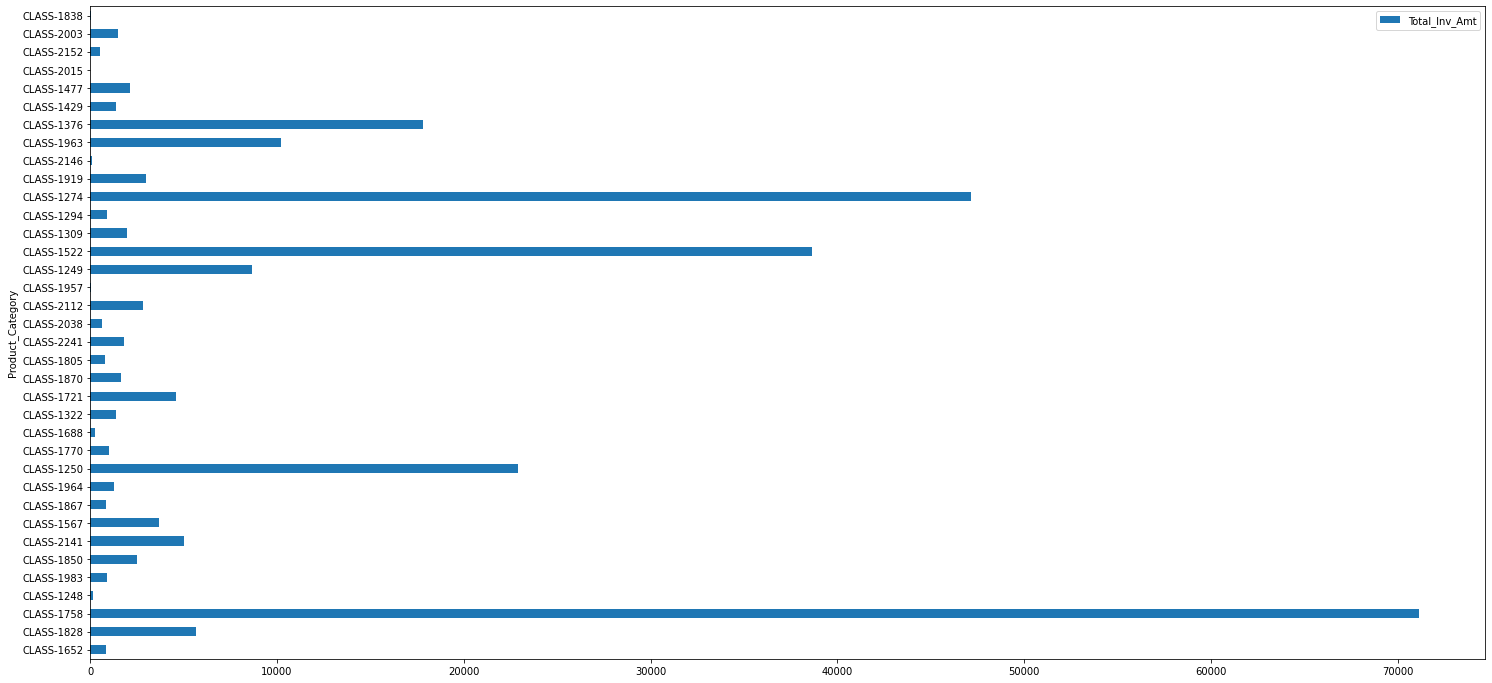

In [10]:
pd_products.plot(x="Product_Category", y=['Total_Inv_Amt'], kind="barh",figsize=(25,12))

<AxesSubplot:ylabel='Product_Category'>

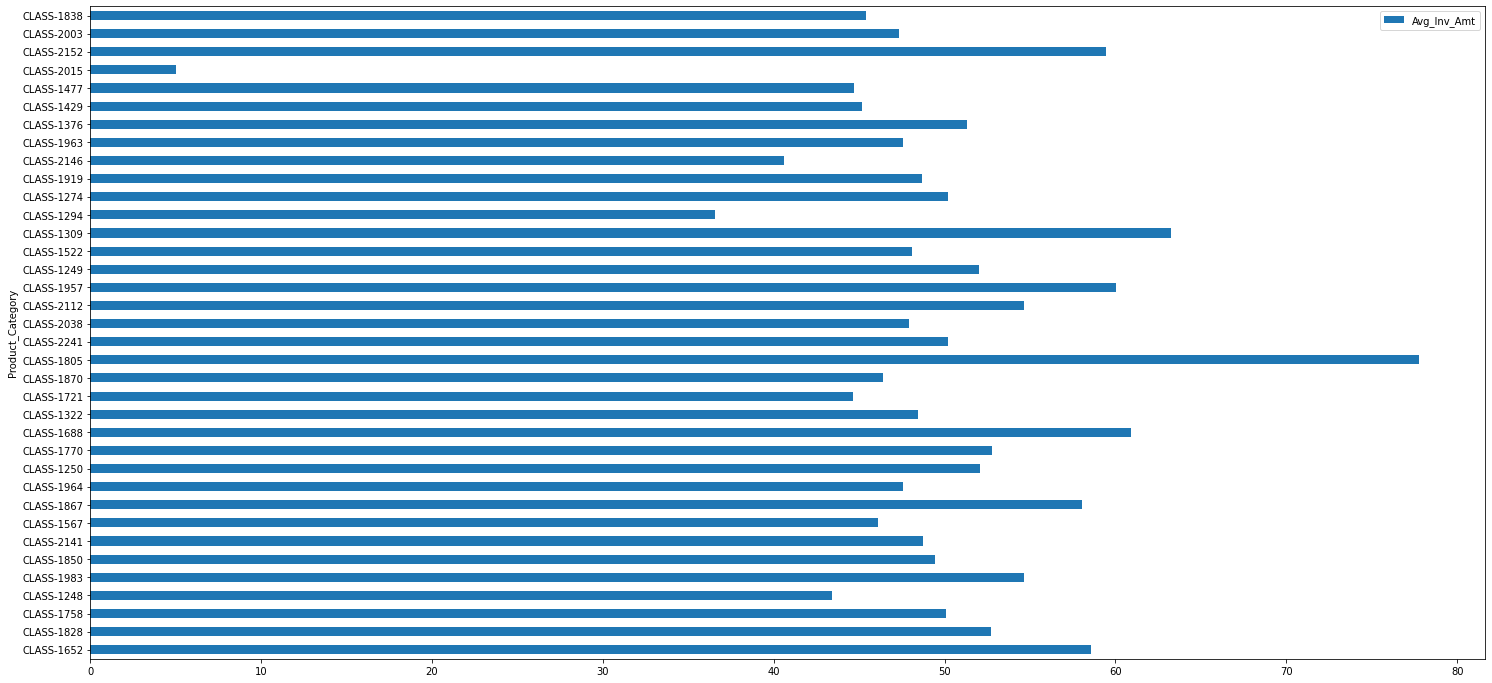

In [11]:
pd_products.plot(x="Product_Category", y=['Avg_Inv_Amt'], kind="barh",figsize=(25,12))

<AxesSubplot:ylabel='Product_Category'>

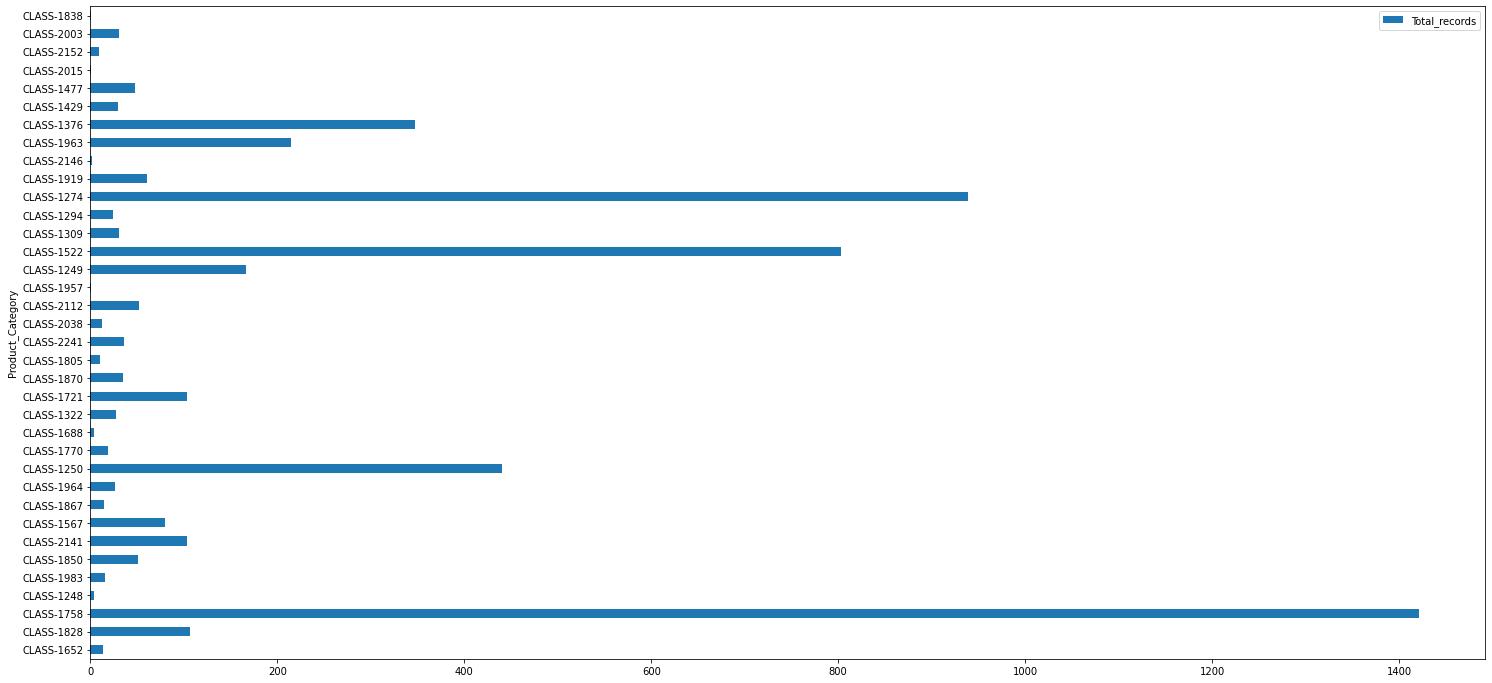

In [12]:
pd_products.plot(x="Product_Category", y=['Total_records'], kind="barh",figsize=(25,12))

<AxesSubplot:ylabel='Product_Category'>

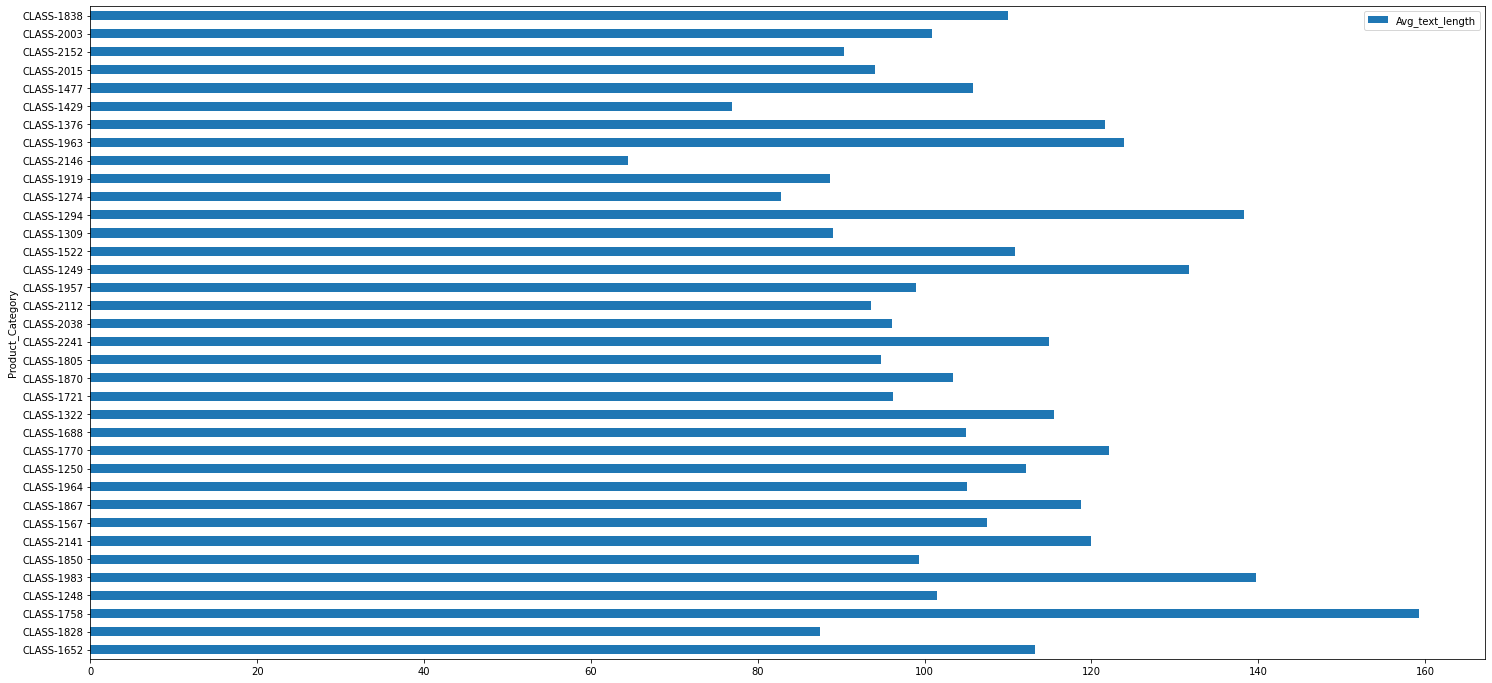

In [13]:
pd_products.plot(x="Product_Category", y=['Avg_text_length'], kind="barh",figsize=(25,12))

In [14]:
# Top 5 Products by Volume and Total average amount.

top_5_prods = pd_products.sort_values(by = ['Total_records','Total_Inv_Amt'],ascending=False)[:5].Product_Category.values

In [15]:
pd_products.sort_values(by = ['Total_records','Total_Inv_Amt'],ascending=False)[:5]

,Product_Category,Total_records,Total_Inv_Amt,Avg_Inv_Amt,Avg_text_length
2,CLASS-1758,1421,71136.15,50.060626,159.237861
25,CLASS-1274,939,47153.57,50.216794,82.790202
22,CLASS-1522,803,38624.53,48.100286,110.830635
10,CLASS-1250,440,22902.55,52.051250,112.161364
29,CLASS-1376,347,17814.97,51.339971,121.587896


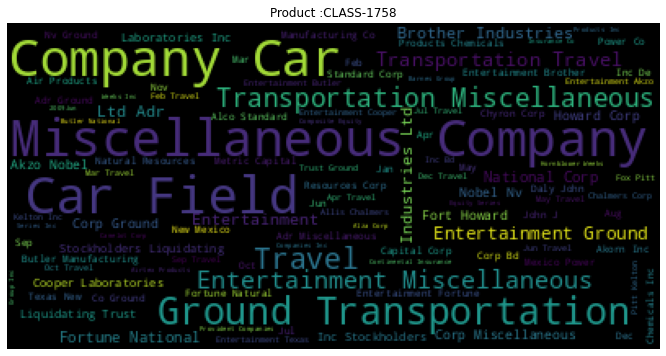

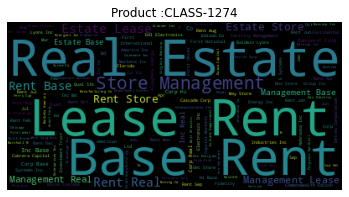

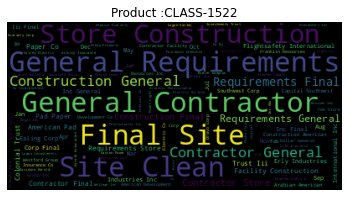

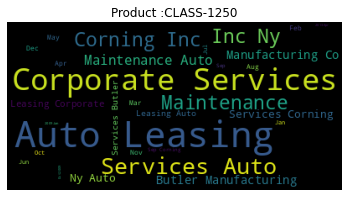

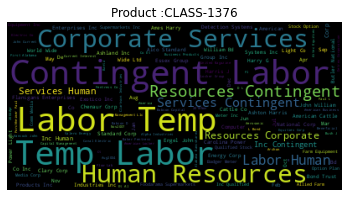

In [19]:
# Wordcloud gives an abstract idea on the highly occuring text data-points

# Description and top words used in top 5 products
text_top_5 = []

for product in top_5_prods:
    prods = data.filter((col("Product_Category") == product))
    prods = prods.select('Item_Description').toPandas()
    text = ','.join(prods['Item_Description'].values)
    text_top_5.append(text)
    

def display_wordcloud(top_words, title, n_components):
    plt.figure(figsize=(25,6))
    j = np.ceil(n_components/2)
    for t in range(n_components):
        i=t+1
        plt.title("Product :" + str(top_5_prods[t]))
        plt.plot()
        plt.imshow(WordCloud().generate(top_words[t])) # WordCloud().fit_words(top_words[t])
        plt.axis("off")
        plt.show()


display_wordcloud(text_top_5, 'title', 5)

In [20]:
# Cleaning text data

data = data.select('*', (lower(col('Item_Description')).alias('Lower_Item_Description'))).drop('Item_Description')

# Tokeizing ( Seperation of sentences into individual words )
tokenizer = Tokenizer(inputCol='Lower_Item_Description', outputCol='words_token')
df_words_token = tokenizer.transform(data).select('Lower_Item_Description', 'words_token')

# Remove stop words ( Removing words which have less impact overall)
remover = StopWordsRemover(inputCol='words_token', outputCol='words_clean')
df_words_no_stopw = remover.transform(df_words_token).select('Lower_Item_Description', 'words_clean')
# df_words_no_stopw.show()

# Lemmetize to bring tenses in a source form
lemmatizer = WordNetLemmatizer()
lemmatizer_udf = udf(lambda tokens: [lemmatizer.lemmatize(token) for token in tokens], ArrayType(StringType()))
df_stemmed = df_words_no_stopw.withColumn("words_stemmed", lemmatizer_udf("words_clean")).select('Lower_Item_Description', 'words_stemmed')
df_stemmed.show()

+----------------------+--------------------+
|Lower_Item_Description|       words_stemmed|
+----------------------+--------------------+
|  artworking/typese...|[artworking/types...|
|  auto leasing corp...|[auto, leasing, c...|
|  store management ...|[store, managemen...|
|  store constructio...|[store, construct...|
|  jul 2015 aydin co...|[jul, 2015, aydin...|
|  final site clean ...|[final, site, cle...|
|  travel and entert...|[travel, entertai...|
|  general contracto...|[general, contrac...|
|  aquila distributo...|[aquila, distribu...|
|  base rent store m...|[base, rent, stor...|
|  ground transporta...|[ground, transpor...|
|  base rent store m...|[base, rent, stor...|
|  real estate lease...|[real, estate, le...|
|  first options of ...|[first, option, c...|
|  chesapeake shores...|[chesapeake, shor...|
|  travel and entert...|[travel, entertai...|
|  final site clean ...|[final, site, cle...|
|  miscellaneous com...|[miscellaneous, c...|
|  smap artworking/t...|[smap, art

In [21]:
text_description = df_stemmed.select('words_stemmed').toPandas()


In [22]:
# Collecting total Corpus

flatten = lambda t: [item for sublist in t for item in sublist]
corpus = flatten(text_description['words_stemmed'].to_list())

processed = [' '.join(i) for i in text_description['words_stemmed'].to_list()]


# Replace numbers with 'numbr'
corpus = [words.replace(r'\d+(\.\d+)?', 'NULL') for words in corpus]
#%%
# Remove punctuation
corpus = [words.replace(r'[^\w\d\s]', ' ') for words in corpus]

# Replace whitespace between terms with a single space
corpus = [words.replace(r'\s+', ' ') for words in corpus]

# Remove leading and trailing whitespace
corpus = [words.replace(r'^\s+|\s+?$', '') for words in corpus]

# Remove quotes
corpus = [words.replace("'", '') for words in corpus]


Total_corpus_size = len(corpus)
Unique_corpus_size = len(set(corpus))
print("Total_corpus_size : ", Total_corpus_size,
      '\n','Unique_corpus_size :',Unique_corpus_size)

Total_corpus_size :  89013 
 Unique_corpus_size : 2557


<AxesSubplot:>

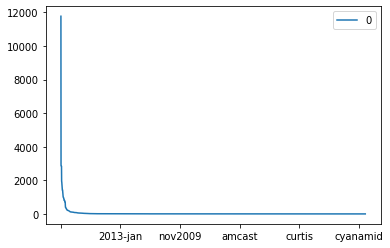

In [23]:
pd.DataFrame(pd.Series(corpus).value_counts()).plot()

In [24]:
# All WordCloud
import PIL
from PIL import Image
mask = np.array(Image.open("cloud.png"))


def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        mask=mask,
        max_words=200,
        max_font_size=70,
        scale=2,
        random_state=1
    ).generate(str(data))
    fig = plt.figure(1, figsize=(25, 25))
    plt.axis('off')
    if title:
        fig.suptitle(title, fontsize=30)
        fig.subplots_adjust(top=2.3)   
    plt.title(title)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.show()

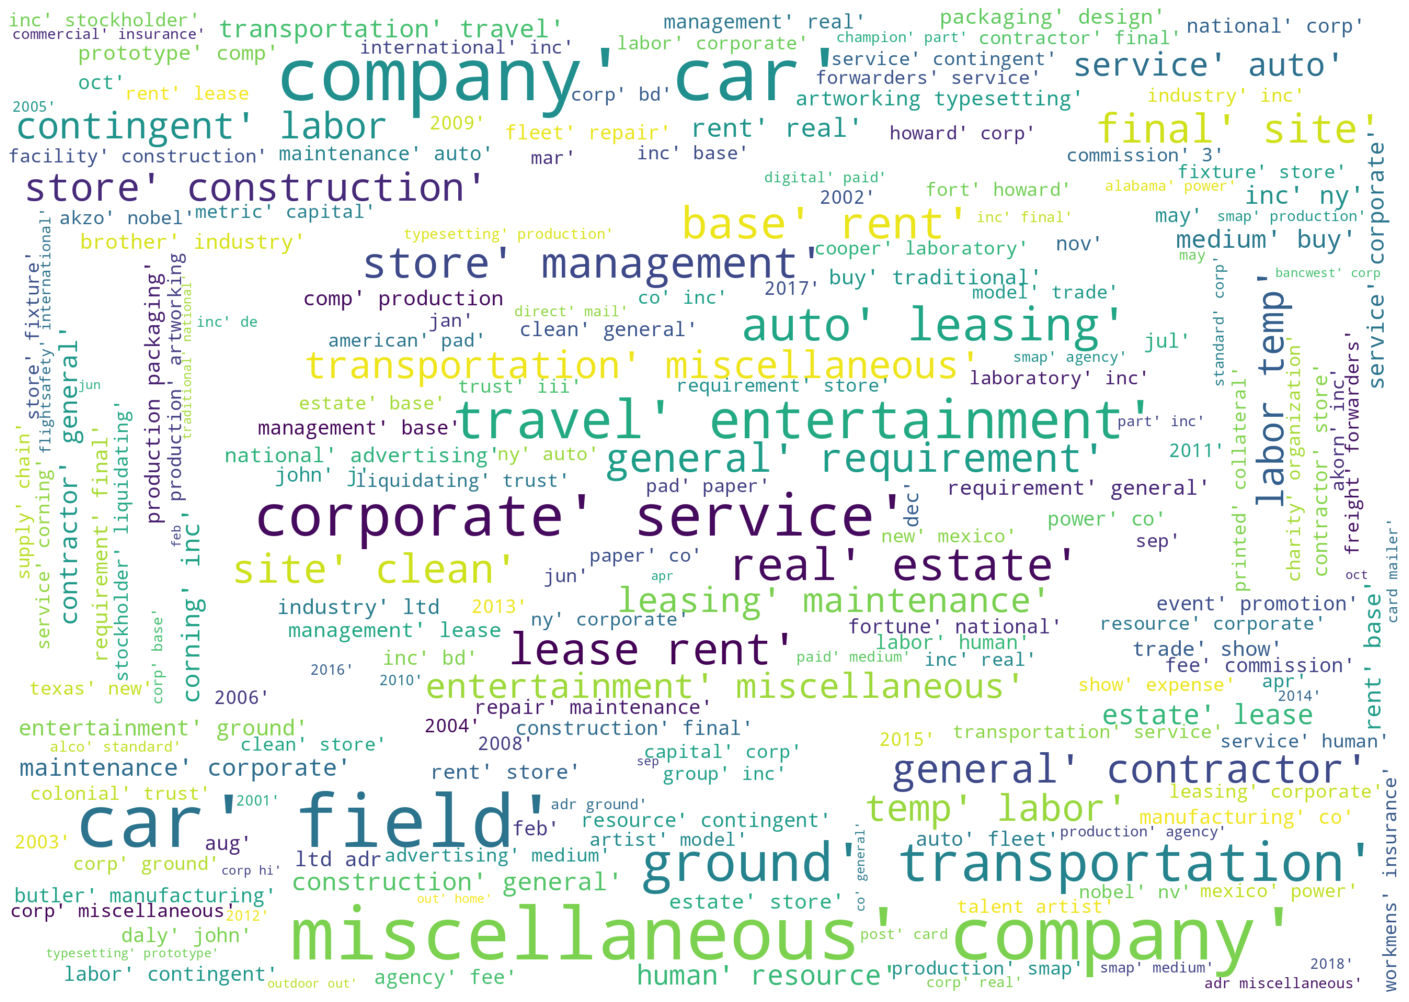

In [25]:
all_words = nltk.FreqDist(corpus)
# print the total number of words and the 150 most common words
# print('Most common words: {}'.format(all_words.most_common(150)))
show_wordcloud(corpus, title = '')

In [35]:
# The bi-grams
esBigrams = ngrams(corpus, 2)

# Frequency of each bigram in the corpus
esBigramFreq = collections.Counter(esBigrams)

# Top 20 Bigrams
esBigramFreq.most_common(20)

[(('', ''), 10446),
 (('miscellaneous', 'company'), 2842),
 (('company', 'car'), 2842),
 (('car', '(field'), 2842),
 (('(field', 'only)'), 2842),
 (('corporate', 'service'), 1661),
 (('travel', 'entertainment'), 1421),
 (('ground', 'transportation'), 1421),
 (('auto', 'leasing'), 1047),
 (('real', 'estate'), 1002),
 (('base', 'rent'), 939),
 (('store', 'management'), 915),
 (('general', 'requirement'), 803),
 (('general', 'contractor'), 803),
 (('final', 'site'), 803),
 (('site', 'clean'), 803),
 (('store', 'construction'), 759),
 (('transportation', 'miscellaneous'), 731),
 (('contingent', 'labor/temp'), 694),
 (('labor/temp', 'labor'), 694)]

In [37]:
# Trigrams

# The tri-grams
esTrigrams = ngrams(corpus, 3)

# Frequency of each trigram in the corpus
esTrigramFreq = collections.Counter(esTrigrams)

# Top 20 tri-grams
esTrigramFreq.most_common(20)

[(('', '', ''), 10125),
 (('miscellaneous', 'company', 'car'), 2842),
 (('company', 'car', '(field'), 2842),
 (('car', '(field', 'only)'), 2842),
 (('final', 'site', 'clean'), 803),
 (('ground', 'transportation', 'miscellaneous'), 731),
 (('transportation', 'miscellaneous', 'company'), 731),
 (('contingent', 'labor/temp', 'labor'), 694),
 (('travel', 'entertainment', 'miscellaneous'), 611),
 (('entertainment', 'miscellaneous', 'company'), 610),
 (('auto', 'leasing', 'maintenance'), 607),
 (('(field', 'only)', 'miscellaneous'), 605),
 (('only)', 'miscellaneous', 'company'), 605),
 (('(field', 'only)', 'ground'), 549),
 (('only)', 'ground', 'transportation'), 549),
 (('corporate', 'service', 'auto'), 540),
 (('service', 'auto', 'leasing'), 496),
 (('real', 'estate', 'lease/rent'), 371),
 (('(field', 'only)', 'travel'), 355),
 (('only)', 'travel', 'entertainment'), 355)]